In [1]:
# !pip install pytesseract
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install opencv-python
# !pip install numpy
# !pip install seaborn

# Объявление переменных датасета и изображения для модели
Сделано для удобной смены датасета и изображения по всём коде

In [2]:
# сбалансированный датасет
IMG_TO_DO="pic2.jpg"
DATASET='data/dataset_milk2.csv'
# несбалансированный датасет
# IMG_TO_DO="pic1.jpg"
# DATASET='data/dataset2.csv'

# Предобработка фотографии для чтения данных
Для предобработки изображения используется библиотека pytesseract, в которую дополнительно загружался русский язык. Изображение, содержащее текст, сканируется и анализируется, чтобы идентифицировать символы в нем. После идентификации символ преобразуется в машинно-кодированный текст

In [3]:

import pytesseract
import cv2
import numpy as np
import re

pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR\\tesseract.exe'


def text_identification(img):
    texts = []
    config = r'--tessdata-dir "C:\Program Files\Tesseract-OCR\tessdata"' 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('res/gray_image.jpg',gray)
    texts.append(pytesseract.image_to_string(gray,  lang = 'rus', config=config))
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    cv2.imwrite('res/threshold_image.jpg',thresh1)
    texts.append(pytesseract.image_to_string(thresh1,  lang = 'rus', config=config))
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations = 3)
    cv2.imwrite('res/dilation_image.jpg',dilation)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    im2 = img.copy()
    cropped_text =''
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Рисуем ограничительную рамку на текстовой области
        rect=cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Обрезаем область ограничительной рамки
        cropped = im2[y:y + h, x:x + w]
        cropped_text += pytesseract.image_to_string(cropped,  lang = 'rus', config=config)
        cv2.imwrite('res/rectanglebox.jpg',rect)
    texts.append(cropped_text)
    return texts
  
        
def find_data_in_text(str):
    datas = np.zeros(4)
    regExp = [
    r'\b[Жж][Ии][Ии]?[Рр](а|ы|ов)?(, г|,г)?\s?[—-]?\s?(от)?\s?[0-9]+[,.\s]?[0-9]',
    r'\bбелк(а|и|ов)?(, г|,г)?\s?[—-]?\s?(не менее)?\s?[0-9]+[,.\s]?[0-9]',
    r'\bуглевод(а|ы|ов)?(, г|,г)?\s?[—-]?\s?[0-9]+[,.\s]?[0-9]',
    r'[\d]+(.[\d]+)?\sккал'
    ]

    for i in range(4):
        finded_slice = re.search(regExp[i], str, re.IGNORECASE)
    if finded_slice:
        specific_numbers=re.search(r'\b[0-9]+[,.\s]?[0-9]', finded_slice[0], re.IGNORECASE)
        number = float(specific_numbers[0].replace(",","."))
        if i == 3:
            datas[i] = number
        else:
            datas[i] = number/ 10 if float(specific_numbers[0].replace(",",".")) > 10 else number

    return datas

def result(pic):
    texts = text_identification(cv2.imread("pics/" + pic))
    data = [0, 0, 0, 0]
    flag = 0
    for text in texts:
        image_data = find_data_in_text(text)
        for i in range(4):
            if(data[i] == 0 and image_data[i] != 0):
                flag += 1
                data[i] = image_data[i]
            if flag == 4:
                break
    return data

# Вспомогательные функции вывода

In [4]:
import itertools

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
        
# pics=["pic1.jpg", "pic2.jpg", "pic4.jpg", "pic5.jpg", "pic6.jpg", "pic7.jpg"]
  
def plot_pred_test(pred, test, name_pred, name_test, name_to_save):
    plt.figure(figsize=(10, 5))
    plt.plot(pred, "r--o" , label=name_pred, markersize=12)
    plt.plot(test,"b--o", label=name_test, markersize=7)
    plt.ylabel('ответ на поставленный вопрос (0 - нет, 1 -да)')
    plt.savefig(name_to_save)
    plt.show()
    
  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          name_to_save="res/conf_matrix.png"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    plt.savefig(name_to_save)
    plt.show()

# Загрузка датасета и его анализ

In [5]:
train = pd.read_csv(DATASET) 
    
train_df = train.copy()
train_df.head(10)


,proteins,fats,carbohydrates,calories,height,weight,age,male,lactose allergy,drink
0,2.8,3.2,4.7,59,151.765,47.825606,63,1,0,0
1,3.5,3.9,5.2,68,167.432,55.336000,45,0,1,1
2,2.9,3.3,4.8,60,155.235,50.802000,55,1,0,0
3,3.2,3.6,5.0,65,162.256,53.948000,50,0,0,1
4,2.7,3.1,4.6,57,148.569,45.359000,70,1,1,0
5,3.8,4.2,5.5,72,170.145,57.232000,40,1,0,1
6,2.6,3.0,4.5,56,145.287,43.023000,75,0,1,0
7,3.0,3.4,4.9,62,158.724,49.895000,60,1,0,0
8,3.6,4.0,5.3,70,169.863,56.214000,42,0,0,1
9,2.5,2.9,4.4,55,142.189,41.446000,80,1,1,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   proteins         201 non-null    float64
 1   fats             201 non-null    float64
 2   carbohydrates    201 non-null    float64
 3   calories         201 non-null    int64  
 4   height           201 non-null    float64
 5   weight           201 non-null    float64
 6   age              201 non-null    int64  
 7   male             201 non-null    int64  
 8   lactose allergy  201 non-null    int64  
 9   drink            201 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 15.8 KB


Убеждаемся, что датасет хороший, т.к. нет пустых значений или полей

# Статистика по числовым значениям поля

In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
proteins,201.0,3.100000,0.606548,2.000000,2.600,3.200,3.600,4.100
fats,201.0,3.420398,0.627321,2.400000,2.800,3.300,4.000,4.500
carbohydrates,201.0,4.923383,0.558928,3.900000,4.500,4.900,5.400,5.900
calories,201.0,62.507463,9.862616,48.000000,53.000,61.000,71.000,86.000
height,201.0,155.608348,16.584793,96.520000,141.893,158.438,170.349,180.732
weight,201.0,48.978173,10.397283,13.267566,39.883,50.407,57.667,65.748
age,201.0,56.965174,22.708892,3.000000,38.000,55.000,76.000,101.000
male,201.0,0.497512,0.501242,0.000000,0.000,0.000,1.000,1.000
lactose allergy,201.0,0.333333,0.472582,0.000000,0.000,0.000,1.000,1.000
drink,201.0,0.477612,0.500746,0.000000,0.000,0.000,1.000,1.000


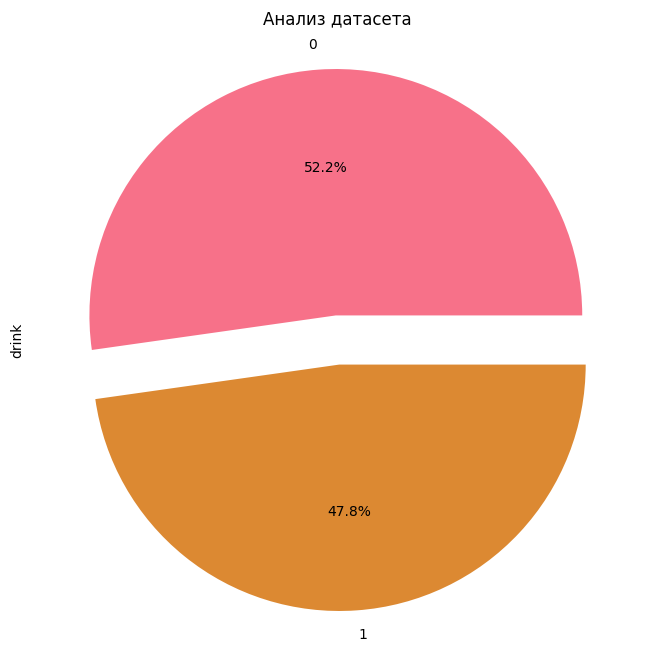

In [8]:
import seaborn as sns

plt.figure(figsize=(8,8))
palette_color = sns.color_palette('husl', 10)
explode = [0.1, 0.1]
train_df.groupby('drink')['drink'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%", title='Анализ датасета');

Датасет получился сбалансированным, что положительно влияет на точность модели и скорость обнаружения

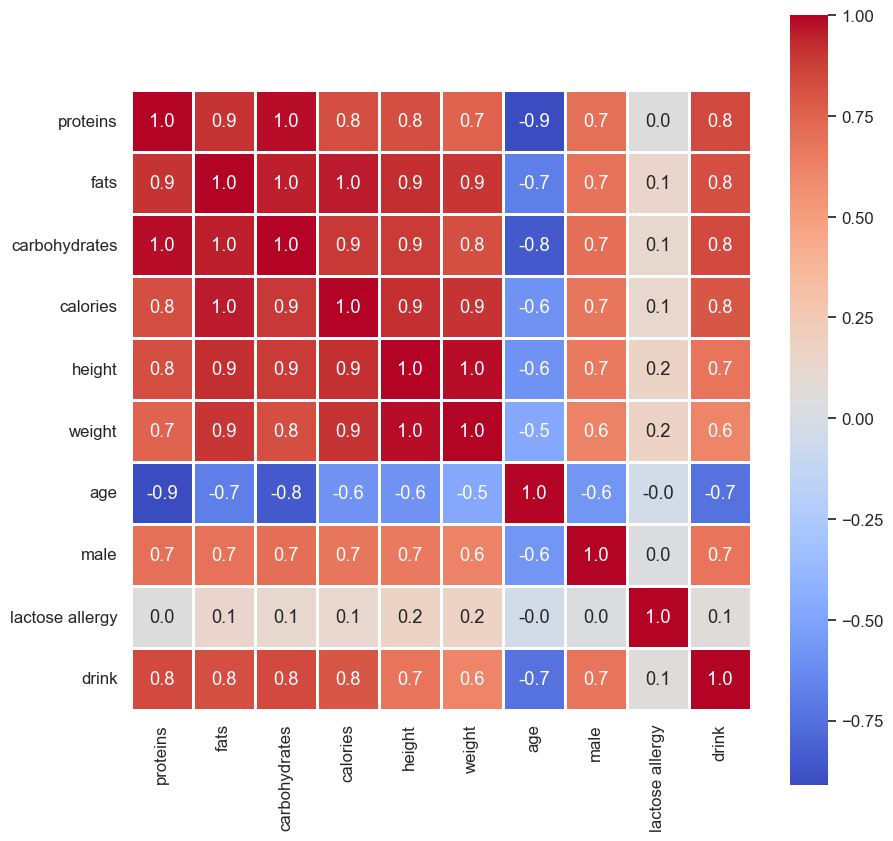

In [9]:
sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            linewidths=1,
            cbar=True);

Мы видим сильную положительную корреляцию с показателями белков, жиров, углеводов и калорий. Также существует некоторая положительная корреляция между рекомендацией употребления молока и ростом/весом. Чуть меньше с возрастом. и полом. И есть не сильно выраженная с аллергией на лактозу. 

In [10]:
def main_functionality():
    train = pd.read_csv(DATASET) 
  
    X = train.drop(["drink"], axis=1).values
    y = train["drink"].values


    X_tarin, X_test, y_train, y_test = train_test_split(X, y)        

    model = GradientBoostingClassifier()

    model.fit(X_tarin, y_train)

    predict = model.predict(X_test)
    plot_pred_test(predict, y_test, "pred", "test", "res/pred_test_GradientBoostingClassifier.png")

    font = {'size' : 10}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, predict)

    plot_confusion_matrix(cnf_matrix, classes=['Нет', 'Да'],
                        title='Матрица Ошибок Для GradientBoostingClassifier', name_to_save="res/conf_matrixGradientBoostingClassifier.png")


    report = classification_report(y_test, predict, target_names=['Нет', 'Да'])
    print(report)

    person = [158, 50, 18, 1, 0]
    milk = result(IMG_TO_DO)
    line = np.array([milk + person])
    print(model.predict(line))

    line_to_dlt_sfx = model.predict(line)
    line_wth_suf = str(line_to_dlt_sfx).removeprefix('[').removesuffix(']')
    
    print(line_wth_suf)
    if line_wth_suf == '1':
        print(line_wth_suf,' - Молоко полезно! Пей и радуйся жизни')
    else:
        print(line_wth_suf, '- Молоко неполезно! Не пей и радуйся жизни')

In [11]:
def tree_function():
    train = pd.read_csv(DATASET) 
  
    X = train.drop(["drink"], axis=1).values
    y = train["drink"].values


    X_tarin, X_test, y_train, y_test = train_test_split(X, y)        

    model = RandomForestClassifier()

    model.fit(X_tarin, y_train)

    predict = model.predict(X_test)
    plot_pred_test(predict, y_test, "pred", "test", "res/pred_test_RandomForestClassifier.png")

    font = {'size' : 10}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, predict)

    plot_confusion_matrix(cnf_matrix, classes=['Нет', 'Да'],
                        title='Матрица Ошибок для RandomForestClassifier', name_to_save="res/conf_matrix_RandomForestClassifier.png")


    report = classification_report(y_test, predict, target_names=['Нет', 'Да'])
    print(report)

    person = [158, 50, 18, 1, 0]
    milk = result(IMG_TO_DO)
    line = np.array([milk + person])

    print(model.predict(line))
    line_to_dlt_sfx = model.predict(line)
    line_wth_suf = str(line_to_dlt_sfx).removeprefix('[').removesuffix(']')
    
    print(line_wth_suf)
    if line_wth_suf == '1':
        print(line_wth_suf,' - Молоко полезно! Пей и радуйся жизни')
    else:
        print(line_wth_suf, '- Молоко неполезно! Не пей и радуйся жизни')
    

# Результаты работы для модели GradientBoostingClassifier


GradientBoostingClassifier - это алгоритм машинного обучения, который основан на идее построения ансамбля слабых моделей, таких как деревья решений, в последовательности, где каждая новая модель настраивается на ошибки предыдущих моделей. Основная идея заключается в том, чтобы постепенно улучшать прогноз, минимизируя ошибку потерь. В отличие от Random Forest, где деревья строятся независимо, в Gradient Boosting деревья строятся итеративно, каждое новое дерево настраивается на остатки предыдущего. Это позволяет модели фокусироваться на ошибках предыдущих моделей, делая его более гибким и мощным в некоторых случаях. Однако GradientBoostingClassifier более склонен к переобучению и может быть более чувствителен к настройке гиперпараметров

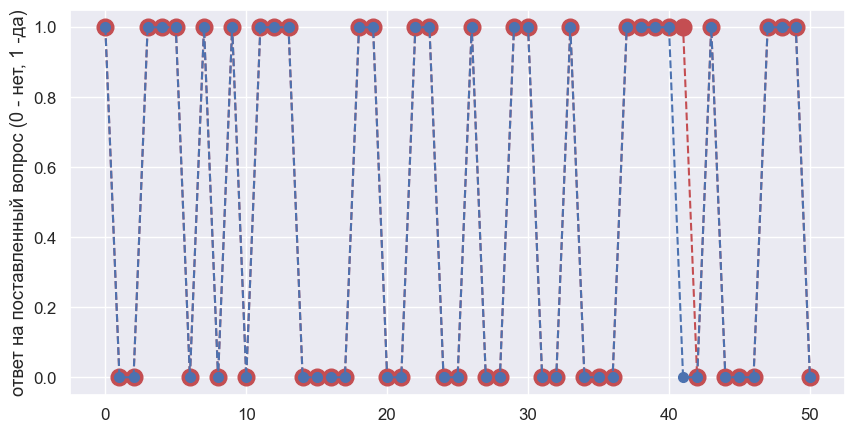

Confusion matrix, without normalization


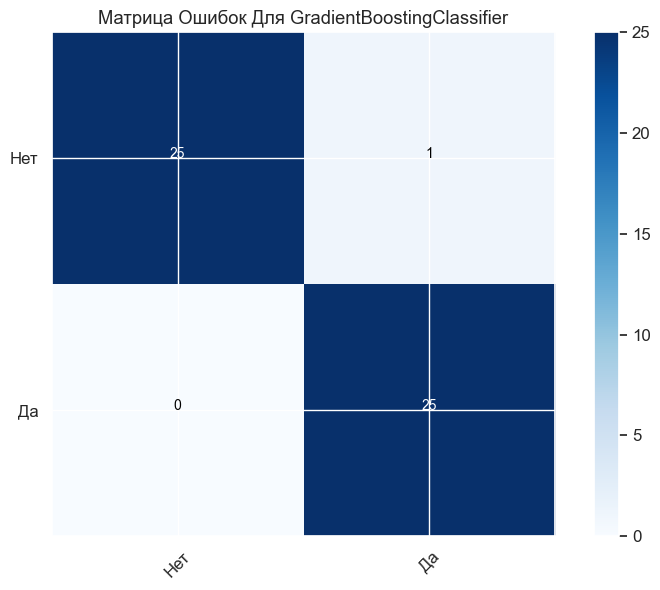

              precision    recall  f1-score   support

         Нет       1.00      0.96      0.98        26
          Да       0.96      1.00      0.98        25

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51

[1]
1
1  - Молоко полезно! Пей и радуйся жизни


In [12]:
main_functionality()

# Результаты работы для модели RandomForestClassifier


RandomForestClassifier - это алгоритм машинного обучения, основанный на методе случайного леса. Он использует ансамбль решающих деревьев для задач классификации. Каждое дерево строится на основе случайной подвыборки данных и случайного подмножества признаков. В процессе прогнозирования, каждое дерево голосует за классификацию объекта, и результат определяется путем голосования.

 RandomForestClassifier хорошо масштабируется, устойчив к переобучению и эффективен для работы с большими наборами данных.

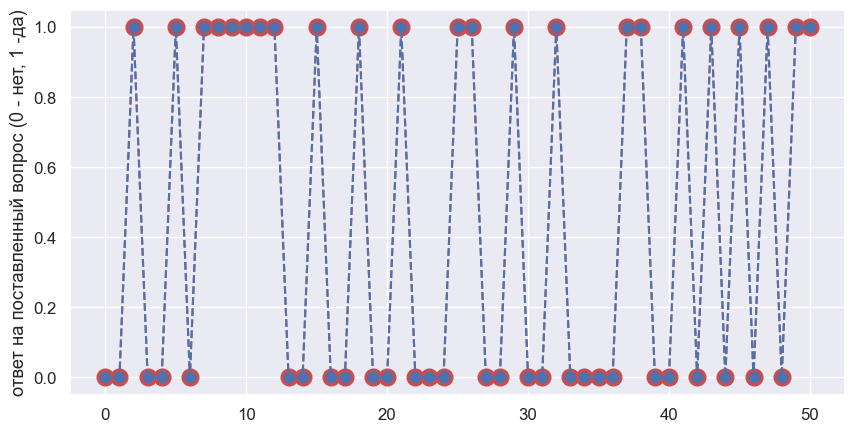

Confusion matrix, without normalization


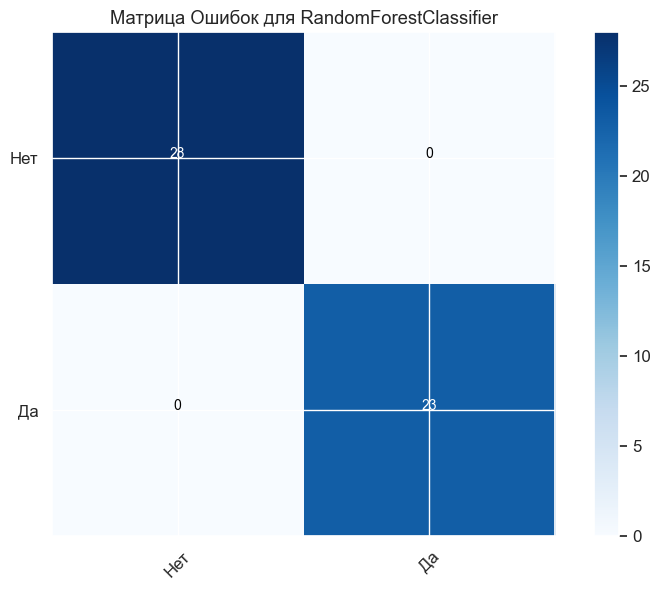

              precision    recall  f1-score   support

         Нет       1.00      1.00      1.00        28
          Да       1.00      1.00      1.00        23

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

[0]
0
0 - Молоко неполезно! Не пей и радуйся жизни


In [13]:
tree_function()

# Используемые метрики

Для исследования моделей была использована функция `classification_report` из библиотеки sklearn (sklearn.metrics). Эта сводка включает в себя следюущие метрики:
1. **Точность (Precision)**:
   - Это процент правильных положительных прогнозов по отношению к общему количеству положительных прогнозов. 
   -  Формула: TP / (TP + FP), где TP - true positive (верно предсказанные положительные), FP - false positive (ложно предсказанные положительные).
 
2. **Полнота (Recall):**
   - Это процент правильных положительных прогнозов по отношению к общему количеству фактических положительных результатов.
   - Формула: TP / (TP + FN), где FN - false negative (ложно предсказанные отрицательные).

3. **F1-мера (F1-score):**
   - Среднее гармоническое между точностью и полнотой. Она является балансом между точностью и полнотой классификации Чем ближе к 1, тем лучше модель..
   - Формула: 2 * (Precision * Recall) / (Precision + Recall)

4. **Поддержка (Support):**
   - Это количество фактических вхождений каждого класса в наборе данных. 
   - Поддержка используется для вычисления средневзвешенных показателей precision, recall и F1.
  
5. **Точность (Accuracy):**
   - Это общая метрика, которая показывает, как часто модель правильно классифицирует объекты. Это полезно для общего понимания производительности модели, особенно если классы в наборе данных сбалансированы.
   - Формула: (TP+TN) / (TP+TN+FP+FN)